In [1]:
import pandas as pd
import numpy as np
import glob
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx
import networkx as nx # for visualizing graphs

import torch_geometric.nn as pyg_nn
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
import torch.optim as optim
from copy import deepcopy
from torch_geometric.nn import GINConv
from torch.utils.data import DataLoader
from torch_geometric.datasets import TUDataset
from sklearn.metrics import *
from torch.nn import Sequential, Linear, ReLU
from deepsnap.dataset import GraphDataset
from deepsnap.batch import Batch

/clusterfs/ml4hep/mpettee/miniconda3/envs/pytorch_geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Simple example:

In [2]:
# Define two (bidirectional) edges: between nodes [0,1] and between nodes [1,2]:
edge_index = torch.tensor([[0, 1, 1, 2], 
                           [1, 0, 2, 1]], dtype=torch.long)

# Define node features 
x = torch.tensor([[-1], # node 0
                  [0],  # node 1
                  [1]], # node 2
                 dtype=torch.float)

# Put it all together
data = Data(x=x, edge_index=edge_index)

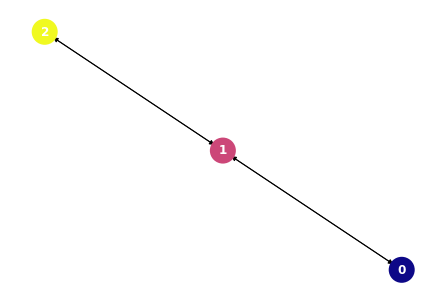

In [3]:
plt.figure() 
nx.draw(to_networkx(data), 
        cmap='plasma', 
        node_color = np.arange(data.num_nodes),
        with_labels=True,
        font_weight='bold',
        font_color='white',
        node_size=400, linewidths=6)

In [4]:
print("Graph nodes have {} node feature(s) each.".format(data.num_node_features))
print("Graph has {} nodes and {} edges.".format(data.num_nodes, data.num_edges))
print("Is the graph undirected?: {}".format(data.is_undirected()))

Graph nodes have 1 node feature(s) each.
Graph has 3 nodes and 4 edges.
Is the graph undirected?: True


# Load the ENZYMES dataset & visualize it

In [68]:
# load the dataset
from torch_geometric.datasets import TUDataset
enzymes = TUDataset(root='/tmp/ENZYMES', name='ENZYMES') 
print("Dataset has {} entries, with {} classes and {} node features.".format(len(enzymes), 
                                                                             enzymes.num_classes, 
                                                                             enzymes.num_node_features))
print("First entry has {:,} nodes and {:,} edges.".format(enzymes[0].num_nodes, enzymes[0].num_edges))
print("Is the graph undirected?: {}".format(enzymes[0].is_undirected()))

# now turn it into graphs
graphs = GraphDataset.pyg_to_graphs(enzymes) 
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)
print("Dataset has {} classes".format(dataset.num_graph_labels))
print("Dataset has {} node features".format(dataset.num_node_features))

Dataset has 600 entries, with 6 classes and 3 node features.
First entry has 37 nodes and 168 edges.
Is the graph undirected?: True
Dataset has 6 classes
Dataset has 3 node features


tensor([3])


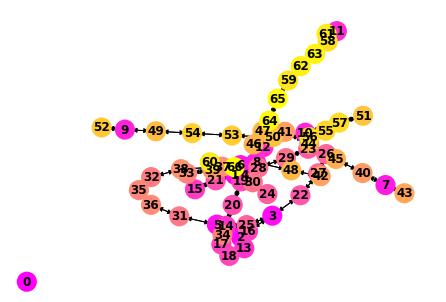

In [69]:
plt.figure() 
print(enzymes[500].y) # overall class of this protein
graph = enzymes[500]
nx.draw(to_networkx(graph), 
        cmap='spring', 
        with_labels=True,
        font_weight='bold',
        node_color = np.arange(graph.num_nodes),
        node_size=200, linewidths=6)

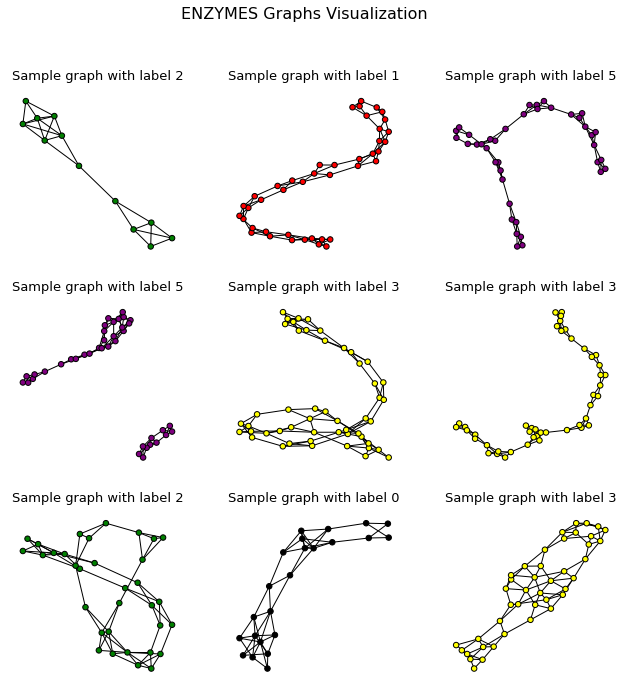

In [10]:
def visualize(dataset):
    color_mapping = {
        0 : 'black',
        1 : 'red',
        2 : 'green',
        3 : 'yellow',
        4 : 'blue',
        5 : 'purple',
    }
    num_graphs_i = 3
    num_graphs_j = 3
    fig, ax = plt.subplots(num_graphs_i, num_graphs_j, figsize=(11, 11))
    fig.suptitle("ENZYMES Graphs Visualization", fontsize=16)
    indices = np.random.choice(np.arange(0, len(dataset)), size=9, replace=False)
    indices = indices.reshape(3, 3)
    for i in range(num_graphs_i):
        for j in range(num_graphs_j):
            index = int(indices[i, j])
            G = dataset[index].G
            label = dataset[index].graph_label.item()
            pos = nx.spring_layout(G, seed=1)
            colors = [color_mapping[label]] * dataset[index].num_nodes
            nodes = nx.draw_networkx_nodes(G, pos=pos, cmap=plt.get_cmap('coolwarm'), \
                node_size=30, ax=ax[(i, j)], node_color=colors)
            nodes.set_edgecolor('black')
            nx.draw_networkx_edges(G, pos=pos, ax=ax[(i, j)])
            ax[(i, j)].set_title("Sample graph with label {}".format(label), fontsize=13)
            ax[(i, j)].set_axis_off()
    plt.show()
visualize(dataset)

Define a basic GNN for graph classification:

In [11]:
class GIN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, args):
        super(GIN, self).__init__()
        self.num_layers = args["num_layers"]

        self.pre_mp = nn.Linear(input_size, hidden_size)
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for l in range(self.num_layers):
            layer = Sequential(
                Linear(hidden_size, hidden_size), 
                nn.LeakyReLU(), 
                Linear(hidden_size, hidden_size)
            )
            self.convs.append(GINConv(layer))
            self.bns.append(nn.BatchNorm1d(hidden_size))
        self.post_mp = Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(), 
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, data):
        x, edge_index, batch = data.node_feature, data.edge_index, data.batch
        x = self.pre_mp(x)
        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)
            x = self.bns[i](x)
        x = self.convs[-1](x, edge_index)
        x = pyg_nn.global_add_pool(x, batch)
        x = self.post_mp(x)
        x = F.log_softmax(x, dim=1)
        return x

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

Define train & test functions:

In [12]:
def train(train_loader, val_loader, test_loader, args, num_node_features, num_classes, device="cpu"):
    model = GIN(num_node_features, args["hidden_size"], num_classes, args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-4)
    best_model = None
    max_val = -1
    for epoch in range(args["epochs"]):
        total_loss = 0
        model.train()
        num_graphs = 0
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            label = batch.graph_label
            loss = model.loss(pred, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs
            num_graphs += batch.num_graphs
        total_loss /= num_graphs
        train_acc = test(train_loader, model, device)
        val_acc = test(val_loader, model, device)
        if val_acc > max_val:
            max_val = val_acc
            best_model = deepcopy(model)
        test_acc = test(test_loader, model, device)
        log = "Epoch {}: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}, Loss: {:.4f}"
        print(log.format(epoch + 1, train_acc, val_acc, test_acc, total_loss))
    return best_model

def test(loader, model, device='cuda'):
    model.eval()
    correct = 0
    num_graphs = 0
    for batch in loader:
        batch.to(device)
        with torch.no_grad():
            pred = model(batch).max(dim=1)[1]
            label = batch.graph_label
        correct += pred.eq(label).sum().item()
        num_graphs += batch.num_graphs
    return correct / num_graphs

Train!

In [13]:
args = {
    "device" : 'cpu', # 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_size" : 50,
    "epochs" : 10,
    "lr" : 0.001,
    "num_layers": 3,
    "dataset" : "ENZYMES",
    "batch_size": 32,
}

pyg_dataset = TUDataset('./tmp/enzymes', args["dataset"])
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)
dataset_train, dataset_val, dataset_test = \
    dataset.split(transductive=False, split_ratio = [0.8, 0.1, 0.1])
num_node_features = dataset.num_node_features
num_classes = dataset.num_graph_labels

In [15]:
train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"], shuffle=True)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])

In [17]:
best_model = train(train_loader, val_loader, test_loader, args, num_node_features, num_classes, args["device"])
train_acc = test(train_loader, best_model, args["device"])
val_acc = test(val_loader, best_model, args["device"])
test_acc = test(test_loader, best_model, args["device"])
log = "Best model: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}"
print(log.format(train_acc, val_acc, test_acc))

Epoch 1: Train: 0.2417, Validation: 0.1667. Test: 0.2167, Loss: 4.4091
Epoch 2: Train: 0.2229, Validation: 0.2500. Test: 0.2333, Loss: 2.1484
Epoch 3: Train: 0.3021, Validation: 0.2333. Test: 0.3000, Loss: 1.8890
Epoch 4: Train: 0.2875, Validation: 0.3333. Test: 0.2667, Loss: 1.6922
Epoch 5: Train: 0.3438, Validation: 0.2000. Test: 0.3000, Loss: 1.6946
Epoch 6: Train: 0.3771, Validation: 0.3000. Test: 0.3333, Loss: 1.6295
Epoch 7: Train: 0.3771, Validation: 0.2500. Test: 0.3167, Loss: 1.6203
Epoch 8: Train: 0.4125, Validation: 0.2333. Test: 0.3667, Loss: 1.5650
Epoch 9: Train: 0.3979, Validation: 0.2667. Test: 0.3333, Loss: 1.5891
Epoch 10: Train: 0.4188, Validation: 0.2833. Test: 0.3167, Loss: 1.5860
Best model: Train: 0.2875, Validation: 0.3333. Test: 0.2667


In [18]:
def test_with_printouts(loader, model, device='cuda'): # with printouts
    model.eval()
    correct = 0
    num_graphs = 0
    batch_num = 0
    for batch in loader:
        print("====== BATCH {} ======".format(batch_num))
        batch.to(device)
        with torch.no_grad():
            pred = model(batch).max(dim=1)[1]
            print("Predicted labels:", pred)
            label = batch.graph_label
            print("True labels:", label)
        correct += pred.eq(label).sum().item()
        num_graphs += batch.num_graphs
        batch_num += 1
        print("Total graphs in batch:", batch.num_graphs)
        print("Number correctly predicted:", pred.eq(label).sum().item())
        print("Accuracy = {:.2f}%".format(100*pred.eq(label).sum().item()/batch.num_graphs))
    print("\nOut of all {} test graphs, {} predictions were correct.".format(num_graphs, correct))
    print("Total accuracy = {:.2f}%".format(100*correct/num_graphs))       
    return correct / num_graphs

In [19]:
test_acc = test_with_printouts(test_loader, best_model, args["device"])

====== BATCH 0 ======
Predicted labels: tensor([3, 0, 3, 1, 2, 3, 3, 2, 3, 3, 3, 2, 3, 2, 1, 1, 3, 0, 0, 1, 1, 2, 0, 3,
        0, 3, 3, 0, 2, 0, 0, 3])
True labels: tensor([4, 3, 5, 1, 5, 2, 4, 2, 1, 5, 3, 2, 5, 2, 2, 0, 2, 0, 4, 2, 0, 0, 5, 2,
        2, 3, 5, 0, 5, 1, 5, 5])
Total graphs in batch: 32
Number correctly predicted: 8
Accuracy = 25.00%
====== BATCH 1 ======
Predicted labels: tensor([2, 3, 1, 3, 4, 3, 2, 3, 3, 3, 1, 3, 3, 2, 0, 0, 2, 0, 0, 3, 3, 2, 0, 2,
        0, 3, 2, 1])
True labels: tensor([0, 1, 4, 3, 4, 3, 0, 4, 1, 3, 5, 4, 1, 2, 3, 0, 4, 1, 3, 3, 2, 2, 3, 1,
        1, 5, 3, 4])
Total graphs in batch: 28
Number correctly predicted: 8
Accuracy = 28.57%

Out of all 60 test graphs, 16 predictions were correct.
Total accuracy = 26.67%


# Okay, now try doing classification on pions as graphs! 

In [20]:
### Load data (multiple files)
pion_files = glob.glob("../data/onetrack_multicluster/pion_files/*.npy")
pi0_files = glob.glob("../data/onetrack_multicluster/pi0_files/*.npy") # obviously very few of these pass the STMC cuts

df_pion = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(pion_files[:1])])
df_pi0 = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(pi0_files)])

print("Pion dataframe has {:,} events.".format(df_pion.shape[0]))
print("Pi0 dataframe has {:,} events.".format(df_pi0.shape[0]))

100%|██████████| 10/10 [00:00<00:00, 21.96it/s]

Pion dataframe has 10,249 events.
Pi0 dataframe has 6,854 events.


In [21]:
def clean_dataframe(df, is_charged = True, max_n_cols=35): 
    ### Start the dataframe of inputs 
    # df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list())[0]) # just take the leading cluster E 
    df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list(), columns=["cluster_e_"+str(x) for x in np.arange(max_n_cols)]))
    
    ### Add track pT & truth particle E 
    track_pt = np.array(df.trackPt.explode())
    truth_particle_e = np.array(df.truthPartE.explode())
    track_eta = np.array(df.trackEta.explode())
    track_phi = np.array(df.trackPhi.explode())
    track_z0 = np.array(df.trackZ0.explode())

    df2["track_pt"] = track_pt
    df2["track_eta"] = track_eta
    df2["track_phi"] = track_phi
    df2["track_z0"] = track_z0
    if is_charged:
        df2["truth_particle_e"] = truth_particle_e
    else:
        df3 = pd.DataFrame(pd.DataFrame(df.truthPartE.to_list(), columns=["truth_particle_e_"+str(x) for x in np.arange(4)]))
        df2["truth_particle_e"] = df3.truth_particle_e_0
        
    ### Cluster_E > 0.5
    df2 = df2[df2.cluster_e_0 > 0.5]

    ### Lose outliers in track pT 
    df2 = df2[df2.track_pt < 5000]

    ### Cast as float
    df2 = df2.astype('float32')

    ### Add the log of all energy variables
    for var in df2.keys():
        if var in ["track_eta", "track_phi", "track_z0"]:
            continue
        else:
            df2['log10_'+var] = np.log10(df2[var])

    ### Drop infs/NaNs 
    df2.replace([np.inf, -np.inf], np.nan, inplace=True)
    df2 = df2.fillna(0)
    
    ### Reduce variables
    
    vars = [
    'log10_cluster_e_0', 
    'log10_track_pt',
    'track_eta', 
    'truth_particle_e'
             ]
    
    df2 = df2[vars]
    
    if is_charged:
        df2['label'] = 1
    else:
        df2['label'] = 0
        
    return df2

In [22]:
df_pion = clean_dataframe(df_pion, is_charged = True, max_n_cols=24)
df_pion

,log10_cluster_e_0,log10_track_pt,track_eta,truth_particle_e,label
0,2.733134,2.755852,-0.046391,718.672852,1
1,0.532984,0.829245,0.250689,6.982437,1
2,2.449312,2.230702,-1.919379,624.100647,1
3,1.436833,1.574001,-0.850665,50.317371,1
4,2.246385,1.939543,1.654420,233.040131,1
...,...,...,...,...,...
10244,2.920279,2.746367,1.361333,1110.349976,1
10245,2.814770,2.555299,-1.924242,1180.081543,1
10246,2.628423,2.075764,-2.137757,554.535095,1
10247,2.070517,1.728981,1.771104,156.071457,1


In [23]:
df_pi0 = clean_dataframe(df_pi0, is_charged = False, max_n_cols=13)
df_pi0

,log10_cluster_e_0,log10_track_pt,track_eta,truth_particle_e,label
0,1.686275,0.591320,-1.602209,57.029118,0
1,1.918844,0.032730,2.443249,113.261826,0
2,2.612776,-0.062958,2.409165,454.409119,0
3,1.201990,0.703816,1.768804,21.921974,0
4,1.264920,0.740012,-1.079699,22.411896,0
...,...,...,...,...,...
6849,2.035302,0.694576,0.261234,117.000282,0
6850,1.048462,0.041859,2.357090,30.642580,0
6851,0.423843,0.437515,-0.465798,3.708041,0
6852,2.819235,0.563282,-2.233699,672.980530,0


In [40]:
df = pd.concat([df_pion, df_pi0])
df = df.sample(frac=1) # shuffle the rows, for good measure
df

,log10_cluster_e_0,log10_track_pt,track_eta,truth_particle_e,label
9998,2.675188,2.677160,0.159545,530.782715,1
707,0.917252,0.735093,-2.454343,33.075172,1
4423,2.076809,2.031066,-0.589452,122.768608,1
9232,2.400573,2.101342,1.962650,472.961761,1
7138,0.707482,0.838367,1.743115,20.614885,1
...,...,...,...,...,...
6675,0.217791,-0.162015,-1.037107,10.271259,0
677,1.324010,1.381862,0.870363,33.998302,1
2696,0.324529,0.569541,-1.140497,6.498630,1
94,1.168927,1.329337,0.887403,30.717787,1


In [139]:
class PionDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dataframe):
        'Initialization'
        self.dataframe = dataframe
        print("")

    def __len__(self):
        'Denotes the total number of samples'
        dataframe = self.dataframe
        return len(dataframe)

    def __getitem__(self, index):
        'Generates one sample of data'  
        dataframe = self.dataframe
        
        ### define nodes 
        cluster_features = ['log10_cluster_e_0']
        track_features = ['log10_track_pt', 'track_eta']
        
        cluster_node = np.array(dataframe.iloc[index][cluster_features])
        cluster_node = np.concatenate([cluster_node, np.zeros(2)]) # cluster features come first
        
        track_node = np.array(dataframe.iloc[index][track_features])
        track_node = np.concatenate([np.zeros(1), track_node]) # cluster features come first

        # shape = (num_nodes, num_node_features) = (2, 3)
        nodes = np.vstack([cluster_node, track_node])        
        
        ### define edges (fully-connected, but no self-loops)
        edges = [(i,j) for i in range(nodes.shape[0]) for j in range(nodes.shape[0]) if i != j]
        edges_reversed = [(i,j) for i in range(nodes.shape[0]) for j in range(nodes.shape[0]) if i != j]
        edge_index = np.row_stack([edges,edges_reversed])
        
        ### Define target 
        label = np.array([dataframe.iloc[index]['label']])
        
        # Convert to torch objects
        nodes = torch.Tensor(nodes)
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        label = torch.from_numpy(label).long()
#         edge_attr = torch.Tensor(is_skeleton_edge)
        
        return Data(x=nodes, y=label, edge_index=edge_index.t().contiguous(), 
#                     edge_attr=edge_attr
                   )

Generate pion graphs:

In [140]:
pions = PionDataset(df)
graphs = GraphDataset.pyg_to_graphs(pions) 
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)
print("Dataset has {} classes".format(dataset.num_graph_labels))
print(len(dataset))
# print("Dataset has {} node features".format(dataset.num_node_features))


Dataset has 2 classes
16818


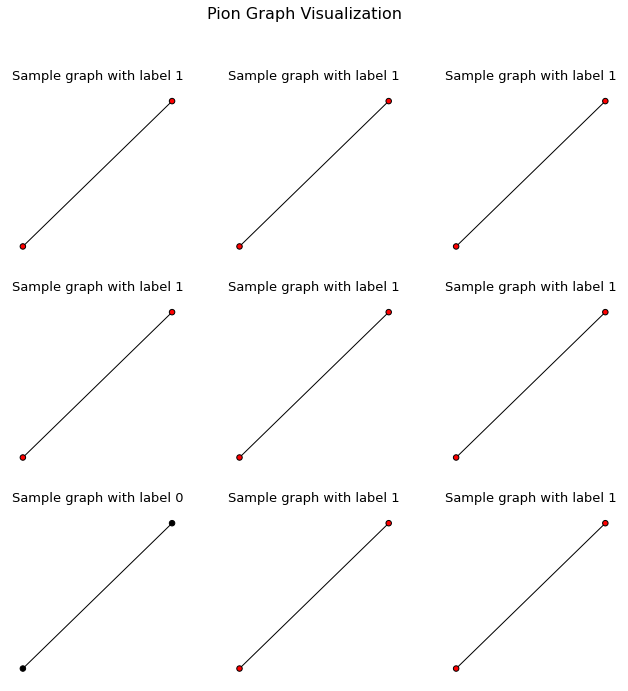

In [141]:
def visualize(dataset):
    color_mapping = {
        0 : 'black',
        1 : 'red',
        2 : 'green',
        3 : 'yellow',
        4 : 'blue',
        5 : 'purple',
    }
    num_graphs_i = 3
    num_graphs_j = 3
    fig, ax = plt.subplots(num_graphs_i, num_graphs_j, figsize=(11, 11))
    fig.suptitle("Pion Graph Visualization", fontsize=16)
    indices = np.random.choice(np.arange(0, len(dataset)), size=9, replace=False)
    indices = indices.reshape(3, 3)
    for i in range(num_graphs_i):
        for j in range(num_graphs_j):
            index = int(indices[i, j])
            G = dataset[index].G
            label = dataset[index].graph_label.item()
            pos = nx.spring_layout(G, seed=1)
            colors = [color_mapping[label]] * dataset[index].num_nodes
            nodes = nx.draw_networkx_nodes(G, pos=pos, cmap=plt.get_cmap('coolwarm'), \
                node_size=30, ax=ax[(i, j)], node_color=colors)
            nodes.set_edgecolor('black')
            nx.draw_networkx_edges(G, pos=pos, ax=ax[(i, j)])
            ax[(i, j)].set_title("Sample graph with label {}".format(label), fontsize=13)
            ax[(i, j)].set_axis_off()
    plt.show()
visualize(dataset)

Visualize a single pion event as a graph:

Graph(G=[], edge_index=[2, 2], edge_label_index=[2, 2], graph_label=[1], node_feature=[2, 3], node_label_index=[2], task=[])
tensor([[1.6434, 0.0000, 0.0000],
        [0.0000, 1.1786, 0.0249]])
Neutral pion
tensor([0])


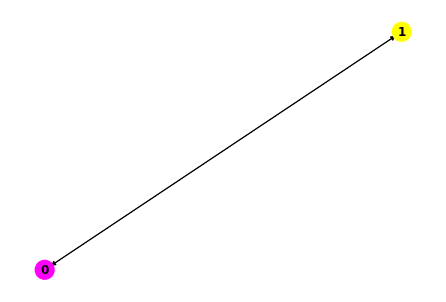

In [142]:
plt.figure() 
graph = dataset[15]
print(graph)
print(graph.node_feature)
if graph.graph_label == 0:
    print("Neutral pion")
elif graph.graph_label == 1:
    print("Charged pion")
print(graph.graph_label)
nx.draw(to_networkx(graph), 
        cmap='spring', 
        with_labels=True,
        font_weight='bold',
        node_color = np.arange(graph.num_nodes),
        node_size=200, linewidths=6)

In [143]:
def train(train_loader, val_loader, test_loader, args, num_node_features, num_classes, device="cpu"):
    model = GIN(num_node_features, args["hidden_size"], num_classes, args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-4)
    best_model = None
    max_val = -1
    for epoch in range(args["epochs"]):
        total_loss = 0
        model.train()
        num_graphs = 0
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            label = batch.graph_label
            loss = model.loss(pred, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs
            num_graphs += batch.num_graphs
        total_loss /= num_graphs
        train_acc = test(train_loader, model, device)
        val_acc = test(val_loader, model, device)
        if val_acc > max_val:
            max_val = val_acc
            best_model = deepcopy(model)
        test_acc = test(test_loader, model, device)
        log = "Epoch {}: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}, Loss: {:.4f}"
        print(log.format(epoch + 1, train_acc, val_acc, test_acc, total_loss))
    return best_model

def test(loader, model, device='cuda'):
    model.eval()
    correct = 0
    num_graphs = 0
    for batch in loader:
        batch.to(device)
        with torch.no_grad():
            pred = model(batch).max(dim=1)[1]
            label = batch.graph_label
        correct += pred.eq(label).sum().item()
        num_graphs += batch.num_graphs
    return correct / num_graphs

In [144]:
args = {
    "device" : 'cpu', # 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_size" : 50,
    "epochs" : 10,
    "lr" : 0.001,
    "num_layers": 3,
    "batch_size": 32,
}

dataset_train, dataset_val, dataset_test = \
    dataset.split(transductive=False, split_ratio = [0.8, 0.1, 0.1])

num_node_features = 3
num_classes = dataset.num_graph_labels

train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"], shuffle=True)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])

best_model = train(train_loader, val_loader, test_loader, args, 
                   num_node_features, num_classes, args["device"])

train_acc = test(train_loader, best_model, args["device"])
val_acc = test(val_loader, best_model, args["device"])
test_acc = test(test_loader, best_model, args["device"])
log = "Best model: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}"
print(log.format(train_acc, val_acc, test_acc))

Epoch 1: Train: 0.9353, Validation: 0.9161. Test: 0.9275, Loss: 0.2316
Epoch 2: Train: 0.9273, Validation: 0.9066. Test: 0.9150, Loss: 0.2024
Epoch 3: Train: 0.9384, Validation: 0.9292. Test: 0.9317, Loss: 0.2041
Epoch 4: Train: 0.9457, Validation: 0.9280. Test: 0.9412, Loss: 0.1933
Epoch 5: Train: 0.9402, Validation: 0.9239. Test: 0.9430, Loss: 0.1951
Epoch 6: Train: 0.9364, Validation: 0.9203. Test: 0.9299, Loss: 0.1848
Epoch 7: Train: 0.9299, Validation: 0.9155. Test: 0.9317, Loss: 0.1812
Epoch 8: Train: 0.9446, Validation: 0.9280. Test: 0.9436, Loss: 0.1879
Epoch 9: Train: 0.9419, Validation: 0.9239. Test: 0.9394, Loss: 0.1808
Epoch 10: Train: 0.9430, Validation: 0.9221. Test: 0.9388, Loss: 0.1777
Best model: Train: 0.9384, Validation: 0.9292. Test: 0.9317


In [145]:
test_acc = test_with_printouts(test_loader, best_model, args["device"])

====== BATCH 0 ======
Predicted labels: tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 1])
True labels: tensor([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 1])
Total graphs in batch: 32
Number correctly predicted: 30
Accuracy = 93.75%
====== BATCH 1 ======
Predicted labels: tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 1])
True labels: tensor([1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 0, 1])
Total graphs in batch: 32
Number correctly predicted: 29
Accuracy = 90.62%
====== BATCH 2 ======
Predicted labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 1])
True labels: tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 1])
Total graphs 

# Pion regression

In [166]:
### Load data (multiple files)
pion_files = glob.glob("../data/onetrack_multicluster/pion_files/*.npy")
df_pion = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(pion_files[:1])])
print("Pion dataframe has {:,} events.".format(df_pion.shape[0]))

100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

Pion dataframe has 10,249 events.


In [167]:
def clean_dataframe(df, max_n_cols=35): 
    ### Start the dataframe of inputs 
    # df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list())[0]) # just take the leading cluster E 
    df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list(), columns=["cluster_e_"+str(x) for x in np.arange(max_n_cols)]))
    
    ### Add track pT & truth particle E 
    track_pt = np.array(df.trackPt.explode())
    truth_particle_e = np.array(df.truthPartE.explode())
    track_eta = np.array(df.trackEta.explode())
    track_phi = np.array(df.trackPhi.explode())
    track_z0 = np.array(df.trackZ0.explode())

    df2["track_pt"] = track_pt
    df2["track_eta"] = track_eta
    df2["track_phi"] = track_phi
    df2["track_z0"] = track_z0
    df2["truth_particle_e"] = truth_particle_e
        
    ### Cluster_E > 0.5
    df2 = df2[df2.cluster_e_0 > 0.5]

    ### Lose outliers in track pT 
    df2 = df2[df2.track_pt < 5000]

    ### Cast as float
    df2 = df2.astype('float32')

    ### Add the log of all energy variables
    for var in df2.keys():
        if var in ["track_eta", "track_phi", "track_z0"]:
            continue
        else:
            df2['log10_'+var] = np.log10(df2[var])

    ### Drop infs/NaNs 
    df2.replace([np.inf, -np.inf], np.nan, inplace=True)
    df2 = df2.fillna(0)
    
    ### Reduce variables
    
    vars = [
    'log10_cluster_e_0', 
    'log10_track_pt',
    'track_eta', 
    'log10_truth_particle_e'
             ]
    
    df2 = df2[vars]
        
    return df2

In [168]:
df_pion = clean_dataframe(df_pion, max_n_cols=24)
df_pion

,log10_cluster_e_0,log10_track_pt,track_eta,log10_truth_particle_e
0,2.733134,2.755852,-0.046391,2.856531
1,0.532984,0.829245,0.250689,0.844007
2,2.449312,2.230702,-1.919379,2.795255
3,1.436833,1.574001,-0.850665,1.701718
4,2.246385,1.939543,1.654420,2.367431
...,...,...,...,...
10244,2.920279,2.746367,1.361333,3.045460
10245,2.814770,2.555299,-1.924242,3.071912
10246,2.628423,2.075764,-2.137757,2.743929
10247,2.070517,1.728981,1.771104,2.193324


In [265]:
class PionDataset_Regress(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dataframe):
        'Initialization'
        self.dataframe = dataframe
        print("")

    def __len__(self):
        'Denotes the total number of samples'
        dataframe = self.dataframe
        return len(dataframe)

    def __getitem__(self, index):
        'Generates one sample of data'  
        dataframe = self.dataframe
        
        ### define nodes 
        cluster_features = ['log10_cluster_e_0']
        track_features = ['log10_track_pt', 'track_eta']
        
        cluster_node = np.array(dataframe.iloc[index][cluster_features])
        cluster_node = np.concatenate([cluster_node, np.zeros(2)]) # cluster features come first
        
        track_node = np.array(dataframe.iloc[index][track_features])
        track_node = np.concatenate([np.zeros(1), track_node]) # cluster features come first

        # shape = (num_nodes, num_node_features) = (2, 3)
        nodes = np.vstack([cluster_node, track_node]) 
        
        ### define edges (fully-connected, but no self-loops)
        edges = [(i,j) for i in range(nodes.shape[0]) for j in range(nodes.shape[0]) if i != j]
        edges_reversed = [(i,j) for i in range(nodes.shape[0]) for j in range(nodes.shape[0]) if i != j]
        edge_index = np.row_stack([edges,edges_reversed])
        
        ### Define target 
        target = np.array([dataframe.iloc[index]['log10_truth_particle_e']])
        
        # Convert to torch objects
        nodes = torch.Tensor(nodes)
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        target = torch.tensor(target)
#         edge_attr = torch.Tensor(is_skeleton_edge)
        
        return Data(x=nodes, y=target, edge_index=edge_index.t().contiguous(), 
#                     edge_attr=edge_attr
                   )

In [266]:
pions = PionDataset_Regress(df_pion)
graphs = GraphDataset.pyg_to_graphs(pions) 
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)
print(len(dataset))


10012


In [267]:
print("Dataset has {} node features".format(dataset.num_node_features))

Dataset has 3 node features


Graph(G=[], edge_index=[2, 2], edge_label_index=[2, 2], graph_label=[1], node_feature=[2, 3], node_label_index=[2], task=[])
tensor([[0.9773, 0.0000, 0.0000],
        [0.0000, 1.2327, 0.2633]])
tensor([1.2492])


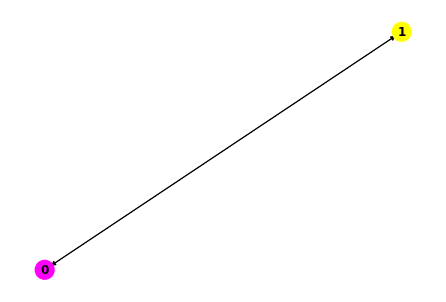

In [268]:
plt.figure() 
graph = dataset[16]
print(graph)
print(graph.node_feature)
print(graph.graph_label)
nx.draw(to_networkx(graph), 
        cmap='spring', 
        with_labels=True,
        font_weight='bold',
        node_color = np.arange(graph.num_nodes),
        node_size=200, linewidths=6)

In [290]:
class GIN_Regress(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, args):
        super(GIN_Regress, self).__init__()
        self.num_layers = args["num_layers"]

        self.pre_mp = nn.Linear(input_size, hidden_size)
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for l in range(self.num_layers):
            layer = Sequential(
                Linear(hidden_size, hidden_size), 
                nn.LeakyReLU(), 
                Linear(hidden_size, hidden_size)
            )
            self.convs.append(GINConv(layer))
            self.bns.append(nn.BatchNorm1d(hidden_size))
        self.post_mp = Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(), 
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, data):
        x, edge_index, batch = data.node_feature, data.edge_index, data.batch
        x = self.pre_mp(x)
        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)
            x = self.bns[i](x)
        x = self.convs[-1](x, edge_index)
        x = pyg_nn.global_add_pool(x, batch)
        x = self.post_mp(x)
#         x = F.log_softmax(x, dim=1)
        return x

    def loss(self, pred, target):
        pred = pred.reshape(pred.shape[0])
        return F.mse_loss(pred, target)

In [500]:
def train(train_loader, val_loader, test_loader, args, num_node_features, output_size, device="cpu"):
    model = GIN_Regress(num_node_features, args["hidden_size"], 1, args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-4)
    best_model = None
    max_val = -1
    for epoch in range(args["epochs"]):
        total_loss = 0
        model.train()
        num_graphs = 0
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            target = batch.graph_label
#             print(target)
            loss = model.loss(pred, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs
            num_graphs += batch.num_graphs
        total_loss /= num_graphs
        train_acc = test(train_loader, model, device)
        val_acc = test(val_loader, model, device)
        if val_acc > max_val:
            max_val = val_acc
            best_model = deepcopy(model)
        test_acc = test(test_loader, model, device)
        log = "Epoch {}: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}, Loss: {:.4f}"
        print(log.format(epoch + 1, train_acc, val_acc, test_acc, total_loss))
    return best_model

def test(loader, model, device='cuda'):
    model.eval()
    ratio = []
    for batch in loader:
        batch.to(device)
        with torch.no_grad():
            pred = model(batch)[:,0] # to make the shapes match
            target = batch.graph_label
            ratio.append(torch.median(torch.divide(pred, target))) 
    return np.median(np.array(ratio))

def test_after_training(loader, model, device='cuda'):
    model.eval()
    preds = []
    targets = []
    ratio = []
    batch_num = 0
    for batch in loader:
#         print("====== BATCH {} ======".format(batch_num))
        batch.to(device)
        with torch.no_grad():
            pred = model(batch)[:,0] # to make the shapes match
            preds.append(pred)
#             print("Predicted energies:", pred)
            target = batch.graph_label
            targets.append(target)
#             print("Truth energies:", target)
#             print("Ratios:", torch.divide(pred, target))
        ratio.append(torch.median(torch.divide(pred, target))) 
        batch_num += 1
#         print("Median ratio per batch: {}".format(torch.median(torch.divide(pred, target))))
    preds_reshaped = torch.cat([torch.stack(preds[:-1]).view(-1, 1), preds[-1].view(-1, 1)])
    targets_reshaped = torch.cat([torch.stack(targets[:-1]).view(-1, 1), targets[-1].view(-1, 1)])
    return np.median(np.array(ratio)), preds_reshaped, targets_reshaped

In [430]:
args = {
    "device" : 'cpu', # 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_size" : 50,
    "epochs" : 10,
    "lr" : 0.001,
    "num_layers": 3,
    "batch_size": 32,
}

dataset_train, dataset_val, dataset_test = \
    dataset.split(transductive=False, split_ratio = [0.8, 0.1, 0.1])

num_node_features = 3

train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"], shuffle=True)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])

best_model = train(train_loader, val_loader, test_loader, args, 
                   num_node_features, 1, args["device"])

train_acc = test(train_loader, best_model, args["device"])
val_acc = test(val_loader, best_model, args["device"])
test_acc = test(test_loader, best_model, args["device"])

# Values printed are best median ratio of predicted energy to target:
log = "Best model: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}"
print(log.format(train_acc, val_acc, test_acc))

Epoch 1: Train: 0.9481, Validation: 0.9493. Test: 0.9487, Loss: 0.2296
Epoch 2: Train: 0.9994, Validation: 0.9981. Test: 0.9998, Loss: 0.0358
Epoch 3: Train: 1.0007, Validation: 1.0010. Test: 0.9937, Loss: 0.0367
Epoch 4: Train: 0.9558, Validation: 0.9526. Test: 0.9519, Loss: 0.0302
Epoch 5: Train: 0.9772, Validation: 0.9756. Test: 0.9812, Loss: 0.0237
Epoch 6: Train: 1.0047, Validation: 1.0022. Test: 1.0031, Loss: 0.0223
Epoch 7: Train: 0.9668, Validation: 0.9700. Test: 0.9694, Loss: 0.0197
Epoch 8: Train: 0.9997, Validation: 0.9966. Test: 1.0018, Loss: 0.0206
Epoch 9: Train: 0.9664, Validation: 0.9680. Test: 0.9692, Loss: 0.0183
Epoch 10: Train: 0.9679, Validation: 0.9678. Test: 0.9688, Loss: 0.0158
Best model: Train: 1.0054, Validation: 1.0022. Test: 1.0031


#### Make plots:

In [502]:
median_ratio, preds, targets = test_after_training(test_loader, best_model, args["device"])

In [503]:
median_ratio

1.0031351

In [504]:
preds = 10**np.array(preds[:,0])
targets = 10**np.array(targets[:,0])

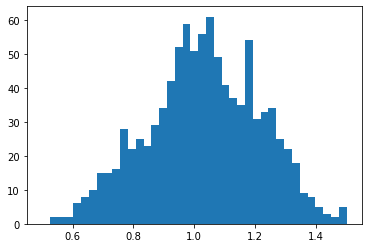

In [506]:
plt.hist(preds/targets, bins=np.linspace(0.5,1.5,40));

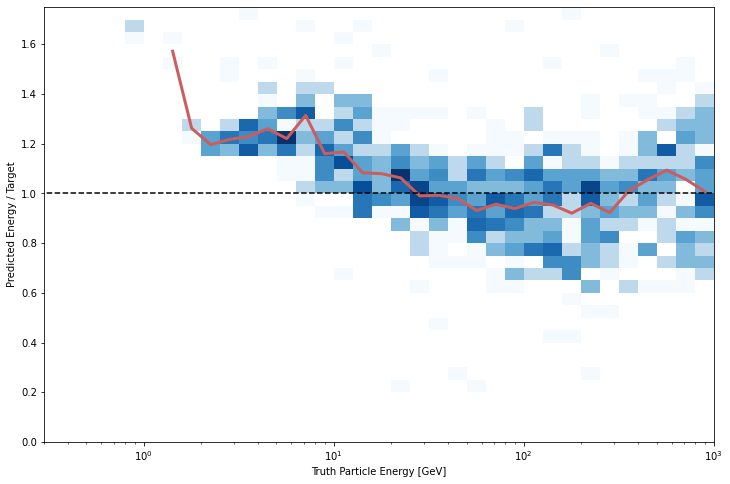

In [512]:
### Response median plot 
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm

x = targets
y = preds/targets

xbin = [10**exp for exp in np.arange(-1., 3.1, 0.1)]
ybin = np.arange(0., 3.1, 0.05)
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
profileXMed = stats.binned_statistic(
    x, y, bins=xbin, statistic='median').statistic

c_map = ListedColormap(sns.color_palette("Blues", n_colors=100).as_hex())
fig = plt.figure(figsize=(12,8))
fig.patch.set_facecolor('white')
plt.hist2d(x, y, bins=[xbin, ybin], norm=LogNorm(),zorder = -1, cmap=c_map);
plt.plot(np.array(xcenter), np.array(profileXMed), color='indianred', linewidth=3)
plt.plot([0.1, 1000], [1, 1], linestyle='--', color='black');
plt.xscale('log')
plt.ylim(0, 1.75)
plt.xlim(0.3, )
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Predicted Energy / Target');
np.savez('pub_note_results/response_median_simple_gnn.npz', response_median=profileXMed, xcenter=xcenter)